In [1]:
import numpy as np
import pandas as pd 
import sklearn
from sklearn import ensemble, linear_model, cross_validation, grid_search
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
import xgboost as xgboost
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
customers_gender = pd.read_csv('customers_gender_train.csv')
customers_gender.head(2)

customer_id  gender
0     75562265       0
1     10928546       1

In [3]:
tr_mcc_codes = pd.read_csv('tr_mcc_codes.csv', sep=';')
tr_mcc_codes.head(5)

mcc_code                                    mcc_description
0       742                                Ветеринарные услуги
1      1711  Генеральные подрядчики по вентиляции, теплосна...
2      1731                        Подрядчики по электричеству
3      1799  Подрядчики, специализированная торговля — нигд...
4      2741           Разнообразные издательства/печатное дело

In [4]:
print len(tr_mcc_codes.mcc_code.unique())
tr_mcc_codes.mcc_code.unique()

184


array([ 742, 1711, 1731, 1799, 2741, 3000, 3351, 3501, 4111, 4112, 4121,
       4131, 4214, 4215, 4411, 4511, 4722, 4784, 4789, 4812, 4814, 4816,
       4829, 4899, 4900, 5013, 5039, 5044, 5045, 5047, 5065, 5072, 5074,
       5085, 5094, 5099, 5111, 5122, 5131, 5137, 5169, 5172, 5192, 5193,
       5199, 5200, 5211, 5231, 5251, 5261, 5300, 5309, 5310, 5311, 5331,
       5399, 5411, 5422, 5441, 5451, 5462, 5499, 5511, 5532, 5533, 5541,
       5542, 5571, 5599, 5611, 5621, 5631, 5641, 5651, 5655, 5661, 5681,
       5691, 5697, 5699, 5712, 5713, 5714, 5719, 5722, 5732, 5733, 5734,
       5735, 5811, 5812, 5813, 5814, 5816, 5912, 5921, 5931, 5940, 5941,
       5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5964, 5965,
       5967, 5968, 5969, 5970, 5971, 5976, 5977, 5983, 5992, 5993, 5994,
       5995, 5999, 6010, 6011, 6012, 6051, 6211, 6300, 6513, 6536, 7011,
       7210, 7216, 7221, 7230, 7273, 7278, 7298, 7299, 7311, 7338, 7372,
       7375, 7395, 7399, 7512, 7523, 7531, 7538, 75

In [5]:
transactions = pd.read_csv('transactions.csv')

In [6]:
transactions.head(2)

customer_id tr_datetime  mcc_code  tr_type    amount term_id
0     39026145  0 10:23:26      4814     1030  -2245.92     NaN
1     39026145  1 10:19:29      6011     7010  56147.89     NaN

In [7]:
tr_type = pd.read_csv('tr_types.csv', sep=';')
tr_type.head(5)

tr_type                                     tr_description
0     3200  Плата за предоставление услуг посредством моби...
1     3210  Плата за предоставление отчета по счету карты ...
2     3800  Плата за обслуживание банковской карты (за пер...
3     4000            Плата за получение наличных в Сбербанке
4     4001  Плата за получение наличных в Сбербанке (в дру...

### feature engineering

In [8]:
customer_id_and_mcc_codes = transactions.groupby('customer_id') \
                    .apply(lambda x: x[['mcc_code']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [26]:
customer_id_and_mcc_codes.head(5)

742   1711  1731  1799  2741  3000  3351  3501  4111  4112  ...   \
customer_id                                                              ...    
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
27914         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
28753         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
31385         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

             8299  8398  8641  8699  8999  9211  9222  9311  9399  9402  
customer_id                                                              
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
27914         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
28753         0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0  
31385         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 184 columns]

In [27]:
customer_id_and_mcc_codes.shape

(15000, 184)

In [28]:
customer_id_mean_amount = transactions.groupby('customer_id') \
                    .apply(lambda x: x[['amount']].unstack().mean())  \
                    .fillna(0)

In [29]:
customer_id_mean_amount.head()

customer_id
6815     -5528.561372
22899    -2691.438419
27914   -26820.061441
28753   -90293.479116
31385    -5972.612548
dtype: float64

In [30]:
customer_id_mean_amount.shape

(15000,)

In [31]:
customer_id_and_tr_type = transactions.groupby('customer_id') \
                    .apply(lambda x: x[['tr_type']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [32]:
customer_id_and_tr_type.head(5)

1000  1010   1030  1100  1110  1200  1210  1310  1410  1510  \
customer_id                                                                
6815          0.0  42.0   90.0   0.0  18.0   0.0   0.0   0.0   0.0   0.0   
22899         0.0   6.0   47.0   0.0  27.0   1.0   0.0   0.0   0.0   0.0   
27914         0.0   0.0   58.0   0.0   1.0   2.0   0.0   0.0   0.0   0.0   
28753         0.0  89.0   25.0   3.0  65.0   0.0   0.0   0.0   0.0   0.0   
31385         0.0  75.0  125.0   0.0  75.0   0.0   0.0   0.0   0.0   0.0   

             ...   7040  7041  7044  7070  7071  7074  7075  8100  8145  8146  
customer_id  ...                                                               
6815         ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
22899        ...    0.0   0.0   0.0   9.0   3.0   0.0   1.0   0.0   0.0   0.0  
27914        ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
28753        ...    1.0   0.0   0.0  14.0   0.0   0.0   0.0   0.0   0.0   0.0  
31385        ...    0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 77 columns]

In [33]:
first_X = pd.concat([customer_id_and_mcc_codes, customer_id_and_tr_type, customer_id_mean_amount], axis=1).reset_index()

In [34]:
first_X.head(5)

customer_id  742  1711  1731  1799  2741  3000  3351  3501  4111  \
0         6815  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1        22899  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2        27914  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3        28753  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4        31385  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

       ...       7041  7044  7070  7071  7074  7075  8100  8145  8146  \
0      ...        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1      ...        0.0   0.0   9.0   3.0   0.0   1.0   0.0   0.0   0.0   
2      ...        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3      ...        0.0   0.0  14.0   0.0   0.0   0.0   0.0   0.0   0.0   
4      ...        0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   

              0  
0  -5528.561372  
1  -2691.438419  
2 -26820.061441  
3 -90293.479116  
4  -5972.612548  

[5 rows x 263 columns]

In [35]:
first_X = first_X.set_index('customer_id')

In [36]:
first_X.columns

Index([ 742, 1711, 1731, 1799, 2741, 3000, 3351, 3501, 4111, 4112,
       ...
       7041, 7044, 7070, 7071, 7074, 7075, 8100, 8145, 8146,    0],
      dtype='object', length=262)

In [37]:
first_X.head(5)

742   1711  1731  1799  2741  3000  3351  3501  4111  4112  \
customer_id                                                               
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
27914         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
28753         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
31385         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                 ...       7041  7044  7070  7071  7074  7075  8100  8145  \
customer_id      ...                                                        
6815             ...        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22899            ...        0.0   0.0   9.0   3.0   0.0   1.0   0.0   0.0   
27914            ...        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
28753            ...        0.0   0.0  14.0   0.0   0.0   0.0   0.0   0.0   
31385            ...        0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   

             8146          0     
customer_id                      
6815          0.0  -5528.561372  
22899         0.0  -2691.438419  
27914         0.0 -26820.061441  
28753         0.0 -90293.479116  
31385         0.0  -5972.612548  

[5 rows x 262 columns]

In [43]:
customers_gender = customers_gender.set_index('customer_id')

In [44]:
y = customers_gender.loc[first_X.index].gender
y = y.reset_index()
del y['customer_id']
y = y.dropna(0)

In [45]:
customers_gender.sort_index().head()

gender
customer_id        
6815              0
22899             1
27914             1
28753             0
31385             0

In [46]:
y.head()

gender
0     0.0
1     1.0
2     1.0
3     0.0
4     0.0

In [8]:
transactions.head()

customer_id tr_datetime  mcc_code  tr_type    amount term_id
0     39026145  0 10:23:26      4814     1030  -2245.92     NaN
1     39026145  1 10:19:29      6011     7010  56147.89     NaN
2     39026145  1 10:20:56      4829     2330 -56147.89     NaN
3     39026145  1 10:39:54      5499     1010  -1392.47     NaN
4     39026145  2 15:33:42      5499     1010   -920.83     NaN

In [9]:
customers_gender.reset_index(inplace=True)

In [10]:
trans = pd.merge(transactions, customers_gender, on='customer_id', how='outer')

In [11]:
customers_gender.set_index("customer_id", inplace=True)

### полезные траты по mcc_code

In [12]:
tmp = pd.merge(pd.crosstab(trans.mcc_code, trans.gender).reset_index(), tr_mcc_codes)
tmp[:5]


mcc_code  0.0  1.0                                    mcc_description
0       742  167   55                                Ветеринарные услуги
1      1711   18   69  Генеральные подрядчики по вентиляции, теплосна...
2      1731    8   65                        Подрядчики по электричеству
3      1799   27   74  Подрядчики, специализированная торговля — нигд...
4      2741   15   18           Разнообразные издательства/печатное дело

In [13]:
abs(tmp[0.0] - tmp[1.0])/(tmp[0.0] + tmp[1.0])
tmp['k'] = (abs(tmp[0.0] - tmp[1.0])/(tmp[0.0] + tmp[1.0]))

tmp.sort('k',  ascending=False, inplace=True)
#del tmp['gender']
tmp.columns = [u'mcc_code', u'ж', u'м', u'mcc_description', u'k']
tmp.set_index(tmp.mcc_code, inplace=True)
#del tmp['mcc_code']
tmp[:10]

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


mcc_code     ж      м  \
mcc_code                          
5967          5967     5    289   
5931          5931   335     39   
1731          1731     8     65   
7995          7995  2431  15650   
7994          7994  1164   7404   
9211          9211    43      7   
6211          6211   133    776   
7512          7512    22    123   
5965          5965   106     19   
7993          7993   106    591   

                                            mcc_description         k  
mcc_code                                                               
5967              Прямой маркетинг — входящий телемаркетинг  0.965986  
5931      Магазины second hand, магазины б/у товаров, ко...  0.791444  
1731                            Подрядчики по электричеству  0.780822  
7995                           Транзакции по азартным играм  0.731099  
7994                            Галереи/учреждения видеоигр  0.728291  
9211      Судовые выплаты, включая алименты и детскую по...  0.720000  
6211                          Ценные бумаги: брокеры/дилеры  0.707371  
7512                                     Прокат автомобилей  0.696552  
5965      Прямой маркетинг — комбинированный каталог и т...  0.696000  
7993                            Принадлежности для видеоигр  0.695839

In [14]:
usefull_mcc = tmp[:10].index

In [15]:
usefull_mcc

Int64Index([5967, 5931, 1731, 7995, 7994, 9211, 6211, 7512, 5965, 7993], dtype='int64', name=u'mcc_code')

In [16]:
extra_feat = pd.DataFrame(index = transactions.customer_id.unique(), columns=usefull_mcc).fillna(0)
extra_feat.head()

mcc_code  5967  5931  1731  7995  7994  9211  6211  7512  5965  7993
39026145     0     0     0     0     0     0     0     0     0     0
52220754     0     0     0     0     0     0     0     0     0     0
78029866     0     0     0     0     0     0     0     0     0     0
79780256     0     0     0     0     0     0     0     0     0     0
1585299      0     0     0     0     0     0     0     0     0     0

In [ ]:
for cust in transactions.customer_id.unique():
    for mcc in usefull_mcc:
        extra_feat.loc[cust, mcc] = transactions[(transactions.customer_id == cust) & (transactions.mcc_code == mcc)].amount.sum()
    print cust

In [24]:
extra_feat.head()

mcc_code  5967  5931  1731  7995  7994  9211  6211  7512  5965  7993
39026145   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
52220754   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
78029866   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
79780256   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
1585299    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [47]:
first_X.shape

(15000, 262)

In [48]:
extra_feat.shape

(15000, 10)

In [52]:
extra_feat.sort_index(inplace=True)

### анализ трат перед 8 марта

In [53]:
transactions['day'] = transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [54]:
transactions.head()

customer_id tr_datetime  mcc_code  tr_type    amount term_id  day
0     39026145  0 10:23:26      4814     1030  -2245.92     NaN    0
1     39026145  1 10:19:29      6011     7010  56147.89     NaN    1
2     39026145  1 10:20:56      4829     2330 -56147.89     NaN    1
3     39026145  1 10:39:54      5499     1010  -1392.47     NaN    1
4     39026145  2 15:33:42      5499     1010   -920.83     NaN    2

In [73]:
men_feat = pd.DataFrame(index = sorted(transactions.customer_id.unique()), columns=['mens']).fillna(0)
men_feat.head()

mens
6815      0
22899     0
27914     0
28753     0
31385     0

In [104]:
for cust in transactions.customer_id.unique():
    summ = transactions[(transactions.day > 215) & \
                        (transactions.day < 223) & \
                        (transactions.customer_id == cust) & \
                        (
                            (transactions.mcc_code == 5992) | 
                            (transactions.mcc_code == 5094) | 
                            (transactions.mcc_code == 5631) | 
                            (transactions.mcc_code == 5944) | 
                            (transactions.mcc_code == 4812) | 
                            (transactions.mcc_code == 5947) 
                        ) \
                         ].amount.sum()
    men_feat.loc[cust,'mens'] = summ

### конкатенация

In [119]:
first_X.shape

(15000, 262)

In [120]:
first_X.head()

742   1711  1731  1799  2741  3000  3351  3501  4111  4112  \
customer_id                                                               
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
27914         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
28753         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
31385         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                 ...       7041  7044  7070  7071  7074  7075  8100  8145  \
customer_id      ...                                                        
6815             ...        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22899            ...        0.0   0.0   9.0   3.0   0.0   1.0   0.0   0.0   
27914            ...        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
28753            ...        0.0   0.0  14.0   0.0   0.0   0.0   0.0   0.0   
31385            ...        0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   

             8146          0     
customer_id                      
6815          0.0  -5528.561372  
22899         0.0  -2691.438419  
27914         0.0 -26820.061441  
28753         0.0 -90293.479116  
31385         0.0  -5972.612548  

[5 rows x 262 columns]

In [121]:
extra_feat.shape

(15000, 10)

In [122]:
extra_feat.head()

mcc_code  5967  5931  1731  7995  7994  9211  6211  7512  5965  7993
6815       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
22899      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
27914      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
28753      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
31385      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [123]:
men_feat.shape

(15000, 1)

In [124]:
men_feat.head()

mens
6815    0.0
22899   0.0
27914   0.0
28753   0.0
31385   0.0

In [125]:
X = pd.concat([first_X, extra_feat, men_feat], axis=1)

In [126]:
X.head()

742  1711  1731  1799  2741  3000  3351  3501  4111  4112  ...   \
customer_id                                                             ...    
6815         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
22899        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
27914        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
28753        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
31385        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

             5931  1731  7995  7994  9211  6211  7512  5965  7993  mens  
customer_id                                                              
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
27914         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
28753         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
31385         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 273 columns]

### X_train - данные для обучения
### y - метки для обучения

In [127]:
X_train = X.reset_index()
X_train = X_train.loc[y.index].set_index('customer_id')

In [128]:
X_train.shape

(12000, 273)

In [129]:
X_train.head(2)

742  1711  1731  1799  2741  3000  3351  3501  4111  4112  ...   \
customer_id                                                             ...    
6815         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
22899        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

             5931  1731  7995  7994  9211  6211  7512  5965  7993  mens  
customer_id                                                              
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[2 rows x 273 columns]

In [130]:
X_train.columns

Index([    742,    1711,    1731,    1799,    2741,    3000,    3351,    3501,
          4111,    4112,
       ...
          5931,    1731,    7995,    7994,    9211,    6211,    7512,    5965,
          7993, u'mens'],
      dtype='object', length=273)

In [131]:
y.head(10)

gender
0      0.0
1      1.0
2      1.0
3      0.0
4      0.0
5      0.0
6      0.0
8      1.0
9      0.0
10     1.0

In [132]:
y.shape

(12000, 1)

In [ ]:
model = sklearn.ensemble.ExtraTreesClassifier(max_features="sqrt", n_estimators=350)
model.fit(X_train, y)
print model.feature_importances_

X_train – данные для обучения, y – метки для обучения

XGB and RF parametrs

In [134]:
param = {}
param['max_depth'] = 6
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['eta'] = 0.05
param['subsample'] = 0.6
param['tree_method'] = 'exact'

In [136]:
mean_xgb = []

num_round_arr = [300, 500, 700, 900]

for num in num_round_arr:
    roc_auc_score_xgb = []
    for j in range(10):
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_train, y, test_size=0.35)
        
        ## xgb_cl
        Xdatatrain = xgboost.DMatrix(data = train_data, label = y_train.gender)
        Xdatatest = xgboost.DMatrix(data = test_data, label = y_test.gender)
        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            
        xgb_cl = xgboost.train(params = plst, dtrain = Xdatatrain, num_boost_round = num)
        
        res_xgb = sklearn.metrics.roc_auc_score(y_test, xgb_cl.predict(Xdatatest))
        roc_auc_score_xgb.append(res_xgb)
    
    print roc_auc_score_xgb
    mean_xgb.append(np.mean(roc_auc_score_xgb))
    print '      xgb_mean = ', np.mean(roc_auc_score_xgb) 

[0.86996839236404477, 0.87588865949517491, 0.86651669124770014, 0.86827418179760341, 0.873227268184398, 0.87091272869365843, 0.86904248784380367, 0.87188145336830947, 0.8801912464077718, 0.86731753617209351]
      xgb_mean =  0.871322064557
[0.86715514663599769, 0.87127927926265958, 0.87577271937796541, 0.87019720013033375, 0.86628433997921128, 0.86663273158909016, 0.87394219540051399, 0.86774797541467596, 0.87302013565148118, 0.87426610328604037]
      xgb_mean =  0.870629782673
[0.86236644120452499, 0.8752703072496244, 0.86368624229638724, 0.86140350227239249, 0.87120850811515527, 0.86955292936266937, 0.86943160651706575, 0.87490823887555558, 0.87141015172592873, 0.86905308767660716]
      xgb_mean =  0.86882910153
[0.86907851552638216, 0.87494695591529192, 0.86907567737962599, 0.86746429577181483, 0.86633619230972136, 0.86563944795859693, 0.87151999937491909, 0.87278256526199216, 0.86699376375641968, 0.86662349552285467]
      xgb_mean =  0.869046090878


In [137]:
mean_xgb = []

num_round_arr = [200, 250, 300, 350]

for num in num_round_arr:
    roc_auc_score_xgb = []
    for j in range(10):
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_train, y, test_size=0.35)
        
        ## xgb_cl
        Xdatatrain = xgboost.DMatrix(data = train_data, label = y_train.gender)
        Xdatatest = xgboost.DMatrix(data = test_data, label = y_test.gender)
        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            
        xgb_cl = xgboost.train(params = plst, dtrain = Xdatatrain, num_boost_round = num)
        
        res_xgb = sklearn.metrics.roc_auc_score(y_test, xgb_cl.predict(Xdatatest))
        roc_auc_score_xgb.append(res_xgb)
    
    print roc_auc_score_xgb
    mean_xgb.append(np.mean(roc_auc_score_xgb))
    print '      xgb_mean = ', np.mean(roc_auc_score_xgb)

[0.86223048028673843, 0.86597362631392483, 0.86512172360728623, 0.87432547079573886, 0.87257045783835085, 0.86581644799309032, 0.86793405266260537, 0.87319758232835265, 0.87085646012124296, 0.86169284266764934]
      xgb_mean =  0.867971914461
[0.86954583685907361, 0.86371128569704436, 0.86769365815796484, 0.86562531522965791, 0.878438635752265, 0.87641280506274266, 0.86782984454202761, 0.87276398763623453, 0.86799669935769308, 0.8759853252741775]
      xgb_mean =  0.870600339357
[0.87561026829772093, 0.86621842563645446, 0.87097932805956091, 0.87334514575706257, 0.87139712748709541, 0.86508726425503124, 0.87018223807984008, 0.87298212464931935, 0.87983330568974127, 0.87033556758329711]
      xgb_mean =  0.87159707955
[0.86518761490958052, 0.8653928109705421, 0.86768977468589992, 0.86745737255941335, 0.87062686454412941, 0.87533882747487357, 0.87358947322848191, 0.87261488316123659, 0.87162415190765707, 0.87861854698589392]
      xgb_mean =  0.870814032043


#### оптимальное NUMROUND = 300

In [139]:
param = {}
param['max_depth'] = 6
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['eta'] = 0.05
param['subsample'] = 0.6
param['tree_method'] = 'exact'

NUMROUND = 300

In [140]:
mean_xgb = []

subsamples  = [0.2, 0.4, 0.6, 0.8]

for sub in subsamples:
    roc_auc_score_xgb = []
    for j in range(10):
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_train, y, test_size=0.35)
        
        param['subsample'] = sub
        
        ## xgb_cl
        Xdatatrain = xgboost.DMatrix(data = train_data, label = y_train.gender)
        Xdatatest = xgboost.DMatrix(data = test_data, label = y_test.gender)
        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            
        xgb_cl = xgboost.train(params = plst, dtrain = Xdatatrain, num_boost_round = NUMROUND)
        
        res_xgb = sklearn.metrics.roc_auc_score(y_test, xgb_cl.predict(Xdatatest))
        roc_auc_score_xgb.append(res_xgb)
    
    print roc_auc_score_xgb
    mean_xgb.append(np.mean(roc_auc_score_xgb))
    print '      xgb_mean = ', np.mean(roc_auc_score_xgb)

[0.87297747319214836, 0.86529784815688426, 0.86322154532634388, 0.86679351241221303, 0.86220127503965471, 0.86289910267171788, 0.86573358798993971, 0.86690768565248733, 0.86450258401670688, 0.8580810418902054]
      xgb_mean =  0.864861565635
[0.87124508338125362, 0.86860946690566887, 0.87084235976878754, 0.86376475214204185, 0.86123237884832227, 0.87110889808127701, 0.872534610534202, 0.87410516687979312, 0.86451357284014296, 0.86614834740012581]
      xgb_mean =  0.868410463678
[0.8735600319909782, 0.86760781371132856, 0.8700032166161199, 0.86592161527412181, 0.86811474499888075, 0.87337792545513704, 0.86919613963416031, 0.86855799283154123, 0.86790098711309882, 0.8687323300661145]
      xgb_mean =  0.869297279769
[0.8739475070242898, 0.86840584805628895, 0.86551798125450607, 0.87331842495969947, 0.87028641071958557, 0.86808453075350123, 0.87465876940770559, 0.86905696941309774, 0.87510244436377238, 0.87093831395718191]
      xgb_mean =  0.870931719991


#### оптимальное subsample = 0.8

In [142]:
param = {}
param['max_depth'] = 6
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['eta'] = 0.05
param['subsample'] = 0.8
param['tree_method'] = 'exact'

NUMROUND = 300

In [ ]:
mean_xgb = []

max_depth_xgb = [2, 4,  6,  8,  12, 14]

for k in max_depth_xgb:
    roc_auc_score_xgb = []
    
    for j in range(10):
        
        param['max_depth'] = k
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_train, y, test_size=0.35)
    
        ## xgb_cl
        Xdatatrain = xgboost.DMatrix(data = train_data, label = y_train.gender)
        Xdatatest = xgboost.DMatrix(data = test_data, label = y_test.gender)
        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            
        xgb_cl = xgboost.train(params = plst, dtrain = Xdatatrain, num_boost_round = NUMROUND)
    
        res_xgb = sklearn.metrics.roc_auc_score(y_test, xgb_cl.predict(Xdatatest))
        print 'xgb_score = ', res_xgb
        roc_auc_score_xgb.append(res_xgb)
   
    mean_xgb.append(np.array(roc_auc_score_xgb).mean())
    print '      xgb_mean = ', np.array(roc_auc_score_xgb).mean()

#### оптимальная глубина 4

In [187]:
param = {}
param['max_depth'] = 4
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['eta'] = 0.05
param['subsample'] = 0.8
param['tree_method'] = 'exact'

NUMROUND = 300

In [ ]:
mean_xgb = []

for i in range(10):
    roc_auc_score_xgb = []
    
    for j in range(15):
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_train, y, test_size=0.35)
    
        ## xgb_cl
        Xdatatrain = xgboost.DMatrix(data = train_data, label = y_train.gender)
        Xdatatest = xgboost.DMatrix(data = test_data, label = y_test.gender)
        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            
        xgb_cl = xgboost.train(params = plst, dtrain = Xdatatrain, num_boost_round = NUMROUND)
    
        res_xgb = sklearn.metrics.roc_auc_score(y_test, xgb_cl.predict(Xdatatest))
        print 'xgb_score = ', res_xgb
        roc_auc_score_xgb.append(res_xgb)
   
    mean_xgb.append(np.array(roc_auc_score_xgb).mean())
    print '      xgb_mean = ', np.array(roc_auc_score_xgb).mean()

#### теперь RF

In [ ]:
mean_rf = []

max_depth = [16, 18, 20, 24, 28]


for d in max_depth:
    roc_auc_score_rf = []
    
    for j in range(7):

        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_train, y, test_size=0.35)
    
        ## rf
        rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=d)
        rf.fit(train_data, y_train)
    
        res_rf = sklearn.metrics.roc_auc_score(y_test, rf.predict_proba(test_data)[ : , 1])
        print 'rf_score = ', res_rf
        roc_auc_score_rf.append(res_rf)


   
    mean_rf.append(np.array(roc_auc_score_rf).mean())
    print '      rf_mean = ', np.array(roc_auc_score_rf).mean()

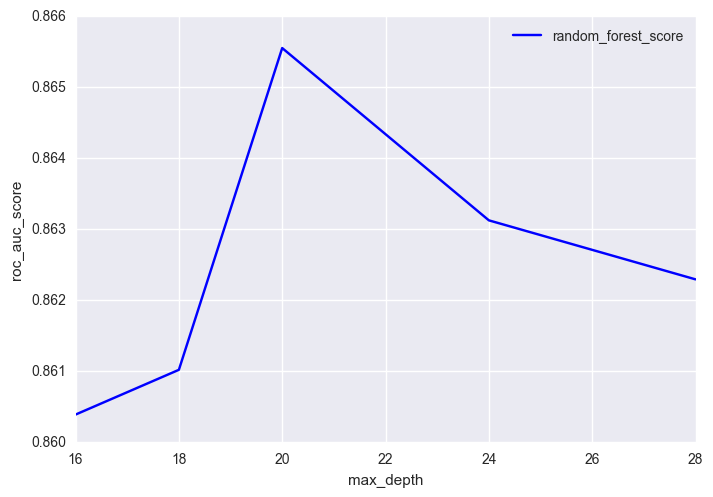

In [162]:
plt.plot(max_depth, mean_rf, c='b')
plt.xlabel('max_depth')
plt.ylabel('roc_auc_score')
plt.legend(['random_forest_score'], loc=0)

### Optimal params:
### I XGB:
    1) numrounds = 300
    2) max_depth = 4
    3) subsample = 0.8
### II RF:
    1) max_depth = 21

### COEF_ for ranking

In [163]:
from scipy.stats import rankdata
import scipy.optimize as opt

In [194]:
def fun(w):
    
    return -sklearn.metrics.roc_auc_score(y_test, (( rankdata(y_rf)*w[0] + rankdata(y_xgb)*(1-w[0]) )/3000) )

In [ ]:
x_mean_rf = []
x_mean_xgb = []
for i in range(10):
    
    train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_train, y, test_size=0.4)
    
    param = {}
    param['max_depth'] = 4
    param['booster'] = 'gbtree'
    param['objective'] = 'binary:logistic'
    param['eval_metric'] = 'auc'
    param['eta'] = 0.05
    param['subsample'] = 0.8
    param['tree_method'] = 'exact'

    NUMROUND = 300
    
    Xdatatrain = xgboost.DMatrix(data = train_data, label = y_train.gender)
    plst = list(param.items())
    xgb_cl = xgboost.train(params = plst, dtrain = Xdatatrain, num_boost_round = NUMROUND)
    
    Xdatatest = xgboost.DMatrix(data = test_data)
    y_xgb = xgb_cl.predict(Xdatatest)
    
    rf = sklearn.ensemble.RandomForestClassifier(n_estimators=250, max_depth=21)
    rf.fit(train_data, y_train)
    y_rf = rf.predict_proba(test_data)[:,1]
    
    root = opt.minimize(fun, method='Nelder-Mead', x0=[0.5])
    print root.x[0]
    print root.fun
    x_mean_rf.append(root.x[0])

print x_mean_rf
print np.mean(x_mean_rf)

In [174]:
np.mean(x_mean_xgb)

0.71962599518206838

### XGB fit

In [197]:
param = {}
param['max_depth'] = 4
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['eta'] = 0.05
param['subsample'] = 0.8
param['tree_method'] = 'exact'

NUMROUND = 300

In [198]:
Xdatatrain = xgboost.DMatrix(data = X_train, label = y.gender)
plst = list(param.items())
xgb_cl = xgboost.train(params = plst, dtrain = Xdatatrain, num_boost_round = NUMROUND)

### XGB pred

In [199]:
X_test = X.drop(customers_gender.index)
result = pd.DataFrame(X_test.index, columns=['customer_id'])

In [200]:
Xdatatest = xgboost.DMatrix(data = X_test)

In [201]:
y_xgb = xgb_cl.predict(Xdatatest)

In [202]:
y_xgb

array([ 0.4335812 ,  0.69396186,  0.73322558, ...,  0.50835228,
        0.53983545,  0.02760638], dtype=float32)

In [203]:
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = y_xgb
result.to_csv('my_sol.csv', index=False)

### RF fit

In [204]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=250, max_depth=21)
rf.fit(X_train, y)

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [205]:
y_rf = rf.predict_proba(X_test)[:,1]

# make submission

In [207]:
result = pd.DataFrame(X_test.index, columns=['customer_id'])
result['gender'] = y_rf * 0.282841796875  + y_xgb * (1-0.282841796876) 

In [208]:
result.to_csv('comb.csv', index=False)